# Transfer Learning

A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features.

 You can visualize this like this:

⇒	Convolutional Layer	Pooling Layer	Convolutional Layer	Pooling Layer	Fully Connected Layer	⇒
Feature Extraction	Classification


Transfer Learning is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners. Fundamentally, a pre-trained model can be a great way to produce an effective classifier even when you have limited data with which to train it.

In this notebook, we'll see how to implement transfer learning for a classification model using PyTorch.

In [ ]:
!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2024-02-28 17:37:51--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.126, 18.160.200.112, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   153MB/s    in 0.3s    

2024-02-28 17:37:51 (153 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.1.0+cu121


In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):

    transformation_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    transformation_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    # Load train images, transforming them
    train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=transformation_train
    )

    # Load train images, transforming them
    val_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'val'),
        transform=transformation_val
    )

    # define a loader for the training data we can iterate through in 30-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=True
    )

    # define a loader for the testing/validation data we can iterate through in 30-image batches
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=False
    )

    return train_loader, val_loader, train_dataset, val_dataset


# Now load the images from the shapes folder
import os
data_path = '/content/hymenoptera_data'

# Get the iterative dataloaders for test and training data
train_loader, val_loader, train_dataset, val_dataset = load_dataset(data_path)

# Get the class names
classes_names = train_dataset.classes
print('class names:', classes_names)

class names: ['ants', 'bees']


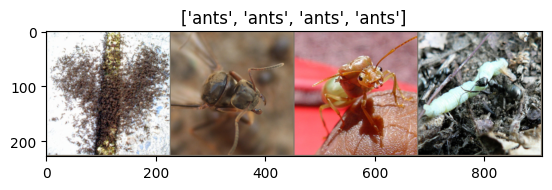

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(val_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_names[x] for x in classes])

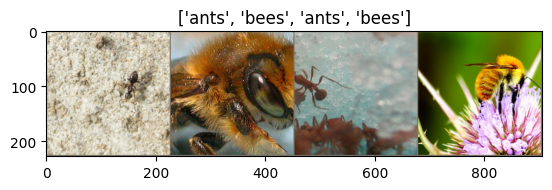

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_names[x] for x in classes])

In [ ]:
  # Now use the train and test functions to train and test the model
  device = "cpu"
  if (torch.cuda.is_available()):
      # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
      device = "cuda"
  print('Training on', device)

Training on cuda


training

In [ ]:
def train(model, device, train_loader, optimizer, loss_criteria, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def test(model, loss_criteria, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_names[preds[j]]}, gt: {classes_names[labels[j].cpu()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def show_loss(epoch_nums, training_loss, validation_loss):
  plt.plot(epoch_nums, training_loss)
  plt.plot(epoch_nums, validation_loss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

def eval_model(model, loader):

  # Set the model to evaluate mode
  model.eval()

  # Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
  print("Getting predictions from test set...")
  truelabels = []
  predictions = []
  for data, target in loader:
      for label in target.cpu().numpy():
          truelabels.append(label)
      with torch.no_grad():
        for prediction in model(data.to(device)).cpu().numpy().argmax(1):
            predictions.append(prediction)

  # Plot the confusion matrix
  cm = confusion_matrix(truelabels, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
  disp.plot()
  plt.show()

In [ ]:
def do_train(model):
  # Create an instance of the model class and allocate it to the device
  model = model.to(device)

  # Use an "Adam" optimizer to adjust weights
  # (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  # Specify the loss criteria
  loss_criteria = nn.CrossEntropyLoss()

  # Track metrics in these arrays
  epoch_nums = []
  training_loss = []
  validation_loss = []

  # Train over 3 epochs (in a real scenario, you'd likely use many more)
  epochs = 3
  for epoch in range(1, epochs + 1):
          train_loss = train(model, device, train_loader, optimizer, loss_criteria, epoch)
          test_loss = test(model, loss_criteria, device, val_loader)
          epoch_nums.append(epoch)
          training_loss.append(train_loss)
          validation_loss.append(test_loss)
  return epoch_nums, training_loss, validation_loss

In [ ]:
baseline_1 = nn.Sequential(nn.Flatten(), nn.Linear(224 * 224 * 3, 2))

result = do_train(baseline_1)
if result is not None:
    epoch_nums, training_loss, validation_loss = result
    # Further processing with epoch_nums, training_loss, and validation_loss
else:
    print("Error: Training function returned None.")


Epoch: 1
Training set [0/244 (0%)] Loss: 0.991963
Training set [40/244 (16%)] Loss: 85.324524
Training set [80/244 (33%)] Loss: 7.491815
Training set [120/244 (49%)] Loss: 37.882126
Training set [160/244 (66%)] Loss: 78.655594
Training set [200/244 (82%)] Loss: 210.786041
Training set [240/244 (98%)] Loss: 34.189785
Training set: Average loss: 55.686808
Validation set: Average loss: 44.811327, Accuracy: 80/153 (52%)

Epoch: 2
Training set [0/244 (0%)] Loss: 23.509071
Training set [40/244 (16%)] Loss: 45.064865
Training set [80/244 (33%)] Loss: 1.737269
Training set [120/244 (49%)] Loss: 134.395859
Training set [160/244 (66%)] Loss: 0.000000
Training set [200/244 (82%)] Loss: 15.745899
Training set [240/244 (98%)] Loss: 4.421310
Training set: Average loss: 39.951374
Validation set: Average loss: 52.430786, Accuracy: 73/153 (48%)

Epoch: 3
Training set [0/244 (0%)] Loss: 26.701145
Training set [40/244 (16%)] Loss: 0.000000
Training set [80/244 (33%)] Loss: 0.000000
Training set [120/244 

In [ ]:
baseline_1 = nn.Sequential(nn.Flatten(), nn.Linear(224 * 224 * 3, 2))

epoch_nums, training_loss, validation_loss = do_train(baseline_1)

# our accuracy is not good just a little more than 50% by cahnce

Epoch: 1
Training set [0/244 (0%)] Loss: 0.402655
Training set [40/244 (16%)] Loss: 35.680511
Training set [80/244 (33%)] Loss: 9.511745
Training set [120/244 (49%)] Loss: 41.399708
Training set [160/244 (66%)] Loss: 0.000000
Training set [200/244 (82%)] Loss: 3.573905
Training set [240/244 (98%)] Loss: 111.017563
Training set: Average loss: 46.329781
Validation set: Average loss: 47.530808, Accuracy: 74/153 (48%)

Epoch: 2
Training set [0/244 (0%)] Loss: 72.803528
Training set [40/244 (16%)] Loss: 54.648605
Training set [80/244 (33%)] Loss: 110.146034
Training set [120/244 (49%)] Loss: 4.028972
Training set [160/244 (66%)] Loss: 37.211746
Training set [200/244 (82%)] Loss: 9.105032
Training set [240/244 (98%)] Loss: 138.481567
Training set: Average loss: 47.931765
Validation set: Average loss: 42.593945, Accuracy: 86/153 (56%)

Epoch: 3
Training set [0/244 (0%)] Loss: 42.569733
Training set [40/244 (16%)] Loss: 75.479691
Training set [80/244 (33%)] Loss: 62.418007
Training set [120/24

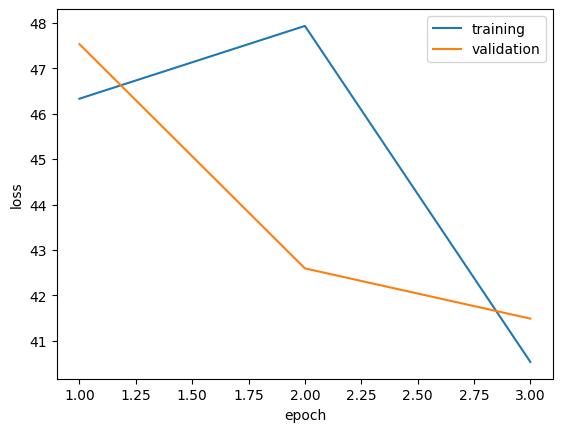

In [ ]:
show_loss(epoch_nums, training_loss, validation_loss)

Getting predictions from test set...


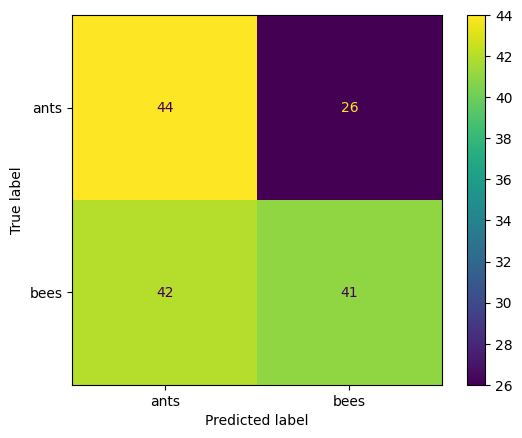

In [ ]:
eval_model(baseline_1, val_loader)

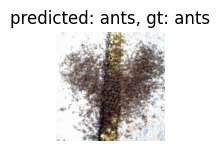

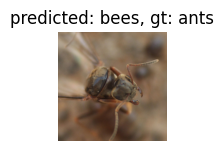

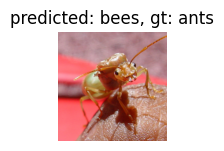

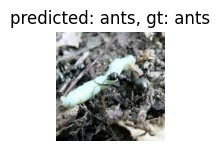

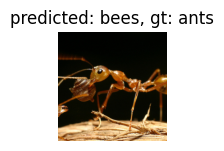

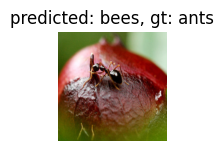

In [ ]:
visualize_model(baseline_1, val_loader)

feature extractor

In [ ]:
# Load the model (download if not already present)
baseline_2 = torchvision.models.resnet18(pretrained=True)

print(baseline_2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# first step:
# (fc): Linear(in_features=512, out_features=1000, bias=True)
# out_features=1000 ---> so we dont need this 1000 classes by resnet and we should change it to our classes



# Set the existing feature extraction layers to read-only
for param in baseline_2.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = baseline_2.fc.in_features
baseline_2.fc = nn.Linear(num_ftrs, len(classes_names)) #(fc): Linear(in_features=512, out_features=1000, bias=True)

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(baseline_2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
epoch_nums, training_loss, validation_loss = do_train(baseline_2)

# you can see our accuracy reach to 95 with the same model just use resnet pretrained weights , nothing else is cahnged

Epoch: 1
Training set [0/244 (0%)] Loss: 0.468545
Training set [40/244 (16%)] Loss: 1.072584
Training set [80/244 (33%)] Loss: 0.575403
Training set [120/244 (49%)] Loss: 0.421299
Training set [160/244 (66%)] Loss: 0.915954
Training set [200/244 (82%)] Loss: 0.414992
Training set [240/244 (98%)] Loss: 0.260873
Training set: Average loss: 0.611866
Validation set: Average loss: 0.322940, Accuracy: 131/153 (86%)

Epoch: 2
Training set [0/244 (0%)] Loss: 0.387377
Training set [40/244 (16%)] Loss: 0.425838
Training set [80/244 (33%)] Loss: 0.215123
Training set [120/244 (49%)] Loss: 0.406447
Training set [160/244 (66%)] Loss: 0.110585
Training set [200/244 (82%)] Loss: 0.636960
Training set [240/244 (98%)] Loss: 0.382668
Training set: Average loss: 0.474254
Validation set: Average loss: 0.249372, Accuracy: 140/153 (92%)

Epoch: 3
Training set [0/244 (0%)] Loss: 0.332614
Training set [40/244 (16%)] Loss: 0.494108
Training set [80/244 (33%)] Loss: 0.474386
Training set [120/244 (49%)] Loss: 0

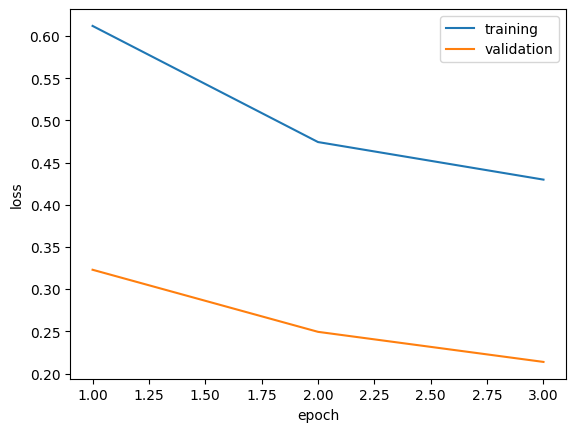

In [ ]:
show_loss(epoch_nums, training_loss, validation_loss)

Getting predictions from test set...


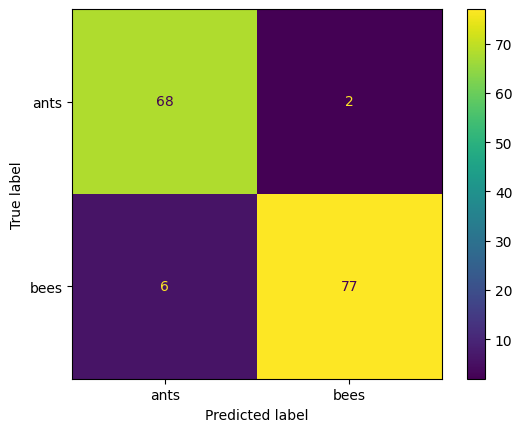

In [ ]:
eval_model(baseline_2, val_loader)

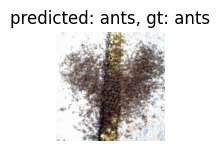

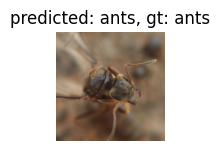

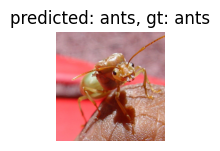

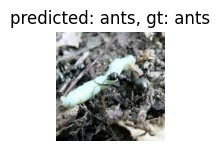

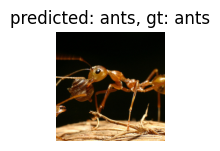

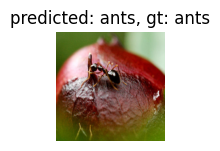

In [ ]:
visualize_model(baseline_2, val_loader)

# End2End FineTuning

To perform end-to-end fine-tuning, you'll need to unfreeze the parameters of the pre-trained model so that they can be updated during training. Additionally, you may need to adjust the learning rate and possibly use differential learning rates for different layers. Below is the modified code with comments to explain the important lines

Libraries imported - ready to use PyTorch 2.1.0+cu121
class names: ['ants', 'bees']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1
Training set [0/244 (0%)] Loss: 0.617401
Training set [40/244 (16%)] Loss: 1.619552
Training set [80/244 (33%)] Loss: 2.072676
Training set [120/244 (49%)] Loss: 1.793812
Training set [160/244 (66%)] Loss: 0.480094
Training set [200/244 (82%)] Loss: 0.556244
Training set [240/244 (98%)] Loss: 0.543282
Training set: Average loss: 0.977131
Validation set: Average loss: 0.715130, Accuracy: 98/153 (64%)

Epoch: 2
Training set [0/244 (0%)] Loss: 0.814117
Training set [40/244 (16%)] Loss: 0.350738
Training set [80/244 (33%)] Loss: 0.948616
Training set [120/244 (49%)] Loss: 0.432962
Training set [160/244 (66%)] Loss: 0.566326
Training set [200/244 (82%)] Loss: 0.326046
Training set [240/244 (98%)] Loss: 0.415952
Training set: Average loss: 0.667341
Validation set: Average loss: 0.857282, Accuracy: 107/153 (70%)

Epoch: 3
Training set [0/244 (0%)] Loss: 0.423799
Training set [40/244 (16%)] Loss: 0.600577
Training set [80/244 (33%)] Loss: 0.740511
Training set [120/244 (49%)] Loss: 0.

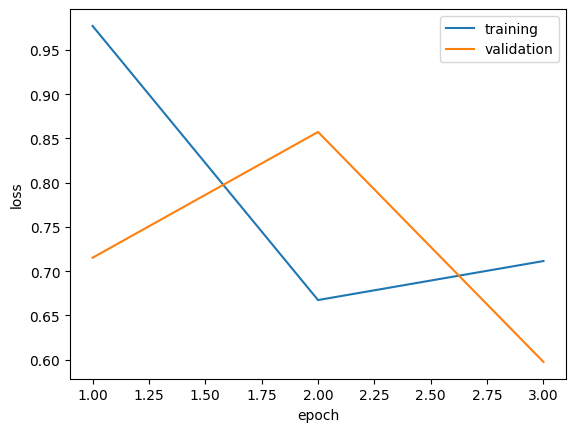

Getting predictions from test set...


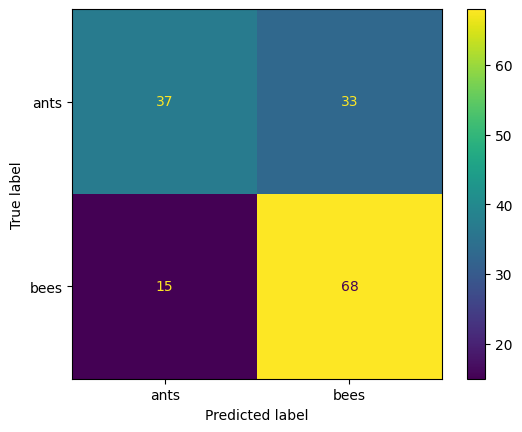

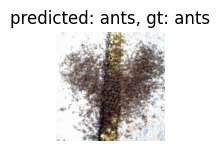

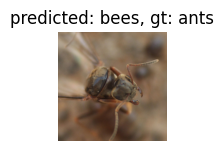

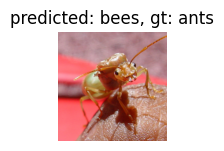

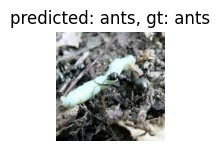

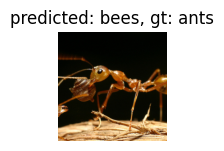

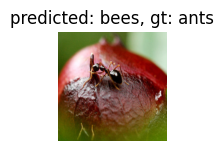

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

# Function to display image
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Function to load dataset
def load_dataset(data_path):
    # Define transformations for training data
    transformation_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Define transformations for validation data
    transformation_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load train and validation datasets
    train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=transformation_train
    )

    val_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'val'),
        transform=transformation_val
    )

    # Define data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=False
    )

    return train_loader, val_loader, train_dataset, val_dataset

# Load dataset
data_path = '/content/hymenoptera_data'
train_loader, val_loader, train_dataset, val_dataset = load_dataset(data_path)
classes_names = train_dataset.classes
print('class names:', classes_names)

# Function to train the model
def train(model, device, train_loader, optimizer, loss_criteria, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

# Function to test the model
def test(model, loss_criteria, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return avg_loss

# Function to visualize the model's predictions
def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_names[preds[j]]}, gt: {classes_names[labels[j].cpu()]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Function to display the training and validation loss
def show_loss(epoch_nums, training_loss, validation_loss):
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

# Function to evaluate the model
def eval_model(model, loader):
    model.eval()
    print("Getting predictions from test set...")
    truelabels = []
    predictions = []
    for data, target in loader:
        for label in target.cpu().numpy():
            truelabels.append(label)
        with torch.no_grad():
            for prediction in model(data.to(device)).cpu().numpy().argmax(1):
                predictions.append(prediction)
    cm = confusion_matrix(truelabels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
    disp.plot()
    plt.show()

# Function to perform training
def do_train(model):
    model = model.to(device)
    # Unfreeze parameters for fine-tuning
    for param in model.parameters():
        param.requires_grad = True
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_criteria = nn.CrossEntropyLoss()
    epoch_nums = []
    training_loss = []
    validation_loss = []
    epochs = 3
    for epoch in range(1, epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, loss_criteria, epoch)
            test_loss = test(model, loss_criteria, device, val_loader)
            epoch_nums.append(epoch)
            training_loss.append(train_loss)
            validation_loss.append(test_loss)
    return epoch_nums, training_loss, validation_loss

# Load the pre-trained ResNet18 model
baseline_2 = torchvision.models.resnet18(pretrained=True)

# Set the existing feature extraction layers to read-only
for param in baseline_2.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = baseline_2.fc.in_features
baseline_2.fc = nn.Linear(num_ftrs, len(classes_names))

# Fine-tune the model
epoch_nums, training_loss, validation_loss = do_train(baseline_2)

# Display training and validation loss
show_loss(epoch_nums, training_loss, validation_loss)

# Evaluate the model
eval_model(baseline_2, val_loader)

# Visualize model predictions
visualize_model(baseline_2, val_loader)


# even if you go to end to end fine tuning your accuracy increase to 69
# still using pretrained model is best choice because accuracy is around 95%



Libraries imported - ready to use PyTorch 2.1.0+cu121
class names: ['ants', 'bees']


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1
Training set [0/244 (0%)] Loss: 1.387596
Training set [40/244 (16%)] Loss: 0.713281
Training set [80/244 (33%)] Loss: 0.445628
Training set [120/244 (49%)] Loss: 0.444307
Training set [160/244 (66%)] Loss: 0.709590
Training set [200/244 (82%)] Loss: 0.869145
Training set [240/244 (98%)] Loss: 0.419324
Training set: Average loss: 0.636706
Validation set: Average loss: 0.364360, Accuracy: 133/153 (87%)

Epoch: 2
Training set [0/244 (0%)] Loss: 0.724348
Training set [40/244 (16%)] Loss: 0.557612
Training set [80/244 (33%)] Loss: 0.310752
Training set [120/244 (49%)] Loss: 0.268201
Training set [160/244 (66%)] Loss: 0.370004
Training set [200/244 (82%)] Loss: 0.432996
Training set [240/244 (98%)] Loss: 0.307440
Training set: Average loss: 0.464088
Validation set: Average loss: 0.248005, Accuracy: 145/153 (95%)

Epoch: 3
Training set [0/244 (0%)] Loss: 0.659828
Training set [40/244 (16%)] Loss: 0.895970
Training set [80/244 (33%)] Loss: 0.489520
Training set [120/244 (49%)] Loss: 0

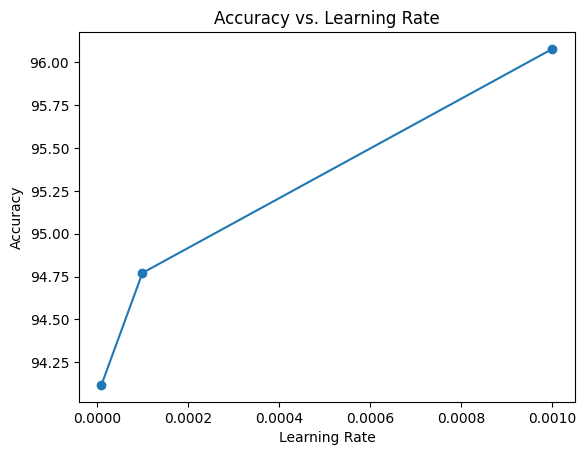

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

# Function to display image
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Function to load dataset
def load_dataset(data_path):
    # Define transformations for training data
    transformation_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Define transformations for validation data
    transformation_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load train and validation datasets
    train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=transformation_train
    )

    val_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'val'),
        transform=transformation_val
    )

    # Define data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=False
    )

    return train_loader, val_loader, train_dataset, val_dataset

# Load dataset
data_path = '/content/hymenoptera_data'
train_loader, val_loader, train_dataset, val_dataset = load_dataset(data_path)
classes_names = train_dataset.classes
print('class names:', classes_names)

# Function to train the model
def train(model, device, train_loader, optimizer, loss_criteria, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

# Function to test the model
def test(model, loss_criteria, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
    avg_loss = test_loss/batch_count
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset), accuracy))
    return avg_loss, accuracy

# Function to visualize the model's predictions
def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_names[preds[j]]}, gt: {classes_names[labels[j].cpu()]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Function to display the training and validation loss
def show_loss(epoch_nums, training_loss, validation_loss):
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

# Function to evaluate the model
def eval_model(model, loader):
    model.eval()
    print("Getting predictions from test set...")
    truelabels = []
    predictions = []
    for data, target in loader:
        for label in target.cpu().numpy():
            truelabels.append(label)
        with torch.no_grad():
            for prediction in model(data.to(device)).cpu().numpy().argmax(1):
                predictions.append(prediction)
    cm = confusion_matrix(truelabels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
    disp.plot()
    plt.show()

# Function to perform training
def do_train(model, learning_rate=0.001): # Add learning_rate as an argument
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Use the specified learning rate
    loss_criteria = nn.CrossEntropyLoss()
    epoch_nums = []
    training_loss = []
    validation_loss = []
    epochs = 3
    for epoch in range(1, epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, loss_criteria, epoch)
            test_loss, accuracy = test(model, loss_criteria, device, val_loader) # Return accuracy as well
            epoch_nums.append(epoch)
            training_loss.append(train_loss)
            validation_loss.append(test_loss)
    return epoch_nums, training_loss, validation_loss, accuracy # Return accuracy

# Load the pre-trained ResNet18 model
baseline_2 = torchvision.models.resnet18(pretrained=True)
for param in baseline_2.parameters():
    param.requires_grad = False
num_ftrs = baseline_2.fc.in_features
baseline_2.fc = nn.Linear(num_ftrs, len(classes_names))

# Try different learning rates and observe accuracy
learning_rates = [0.001, 0.0001, 0.00001] # Define different learning rates
accuracies = []
for lr in learning_rates:
    epoch_nums, training_loss, validation_loss, accuracy = do_train(baseline_2, lr) # Pass learning rate
    accuracies.append(accuracy)

# Plot accuracies for different learning rates
plt.plot(learning_rates, accuracies, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Learning Rate')
plt.show()


Libraries imported - ready to use PyTorch 2.1.0+cu121
class names: ['ants', 'bees']
Learning Rate: 0.001
Epoch: 1
Training set [0/244 (0%)] Loss: 0.344763
Training set [40/244 (16%)] Loss: 0.813448
Training set [80/244 (33%)] Loss: 1.044727
Training set [120/244 (49%)] Loss: 0.537244
Training set [160/244 (66%)] Loss: 0.858207
Training set [200/244 (82%)] Loss: 0.435507
Training set [240/244 (98%)] Loss: 0.454081
Training set: Average loss: 0.749794
Validation set: Average loss: 0.535885, Accuracy: 107/153 (70%)

Epoch: 2
Training set [0/244 (0%)] Loss: 0.374004
Training set [40/244 (16%)] Loss: 0.343346
Training set [80/244 (33%)] Loss: 0.657704
Training set [120/244 (49%)] Loss: 0.429348
Training set [160/244 (66%)] Loss: 0.605744
Training set [200/244 (82%)] Loss: 0.269278
Training set [240/244 (98%)] Loss: 0.206887
Training set: Average loss: 0.470289
Validation set: Average loss: 0.295003, Accuracy: 138/153 (90%)

Epoch: 3
Training set [0/244 (0%)] Loss: 0.606365
Training set [40/

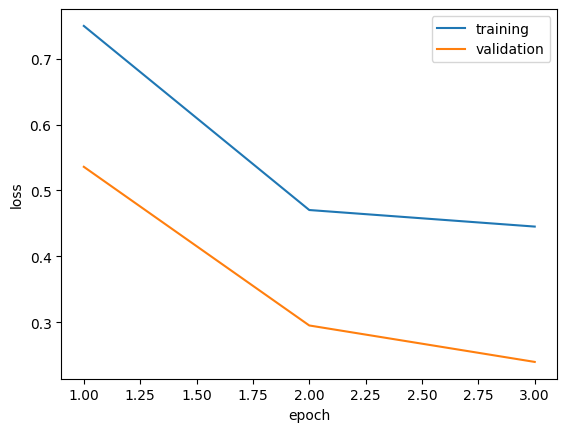

Accuracy with learning rate 0.001: 91.50326797385621%

Learning Rate: 0.0001
Epoch: 1
Training set [0/244 (0%)] Loss: 0.570665
Training set [40/244 (16%)] Loss: 0.204501
Training set [80/244 (33%)] Loss: 0.510179
Training set [120/244 (49%)] Loss: 0.760125
Training set [160/244 (66%)] Loss: 0.204753
Training set [200/244 (82%)] Loss: 0.605131
Training set [240/244 (98%)] Loss: 0.218412
Training set: Average loss: 0.445026
Validation set: Average loss: 0.249692, Accuracy: 140/153 (92%)

Epoch: 2
Training set [0/244 (0%)] Loss: 0.186700
Training set [40/244 (16%)] Loss: 0.180760
Training set [80/244 (33%)] Loss: 0.402409
Training set [120/244 (49%)] Loss: 0.396466
Training set [160/244 (66%)] Loss: 0.741846
Training set [200/244 (82%)] Loss: 0.131527
Training set [240/244 (98%)] Loss: 0.773802
Training set: Average loss: 0.408724
Validation set: Average loss: 0.238611, Accuracy: 141/153 (92%)

Epoch: 3
Training set [0/244 (0%)] Loss: 0.131781
Training set [40/244 (16%)] Loss: 0.372332
Tr

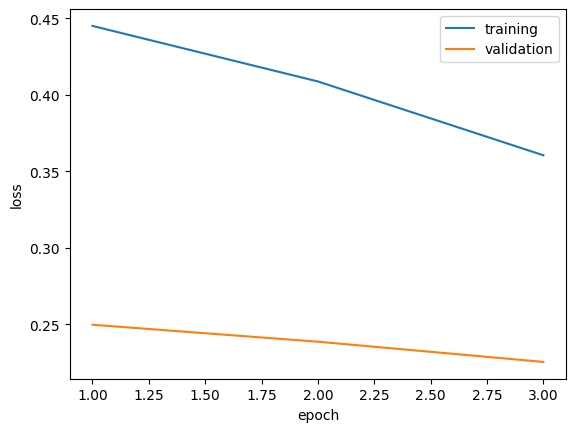

Accuracy with learning rate 0.0001: 92.81045751633987%

Learning Rate: 1e-05
Epoch: 1
Training set [0/244 (0%)] Loss: 0.293617
Training set [40/244 (16%)] Loss: 0.107466
Training set [80/244 (33%)] Loss: 0.412404
Training set [120/244 (49%)] Loss: 0.495984
Training set [160/244 (66%)] Loss: 0.680532
Training set [200/244 (82%)] Loss: 0.096521
Training set [240/244 (98%)] Loss: 0.192582
Training set: Average loss: 0.405458
Validation set: Average loss: 0.242643, Accuracy: 142/153 (93%)

Epoch: 2
Training set [0/244 (0%)] Loss: 0.277392
Training set [40/244 (16%)] Loss: 0.254116
Training set [80/244 (33%)] Loss: 0.211638
Training set [120/244 (49%)] Loss: 0.394476
Training set [160/244 (66%)] Loss: 0.708264
Training set [200/244 (82%)] Loss: 0.309606
Training set [240/244 (98%)] Loss: 0.182695
Training set: Average loss: 0.418672
Validation set: Average loss: 0.239548, Accuracy: 142/153 (93%)

Epoch: 3
Training set [0/244 (0%)] Loss: 0.097024
Training set [40/244 (16%)] Loss: 0.827997
Tr

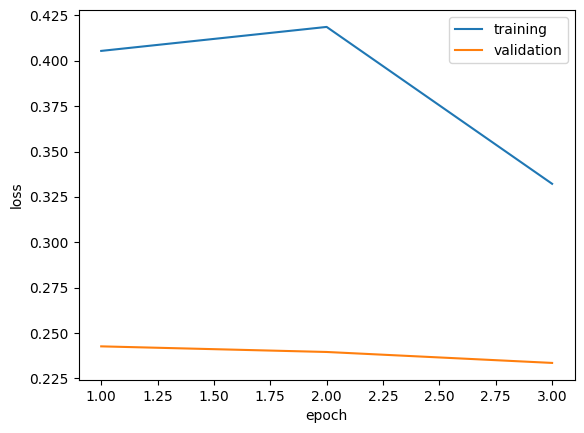

Accuracy with learning rate 1e-05: 93.4640522875817%



In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

# Function to display image
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Function to load dataset
def load_dataset(data_path):
    # Define transformations for training data
    transformation_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Define transformations for validation data
    transformation_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
#transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # Load train and validation datasets
    train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=transformation_train
    )

    val_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'val'),
        transform=transformation_val
    )

    # Define data loaders for training and validation
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=False
    )

    return train_loader, val_loader, train_dataset, val_dataset

# Load dataset
data_path = '/content/hymenoptera_data'
train_loader, val_loader, train_dataset, val_dataset = load_dataset(data_path)
classes_names = train_dataset.classes
print('class names:', classes_names)

# Function to train the model
def train(model, device, train_loader, optimizer, loss_criteria, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

# Function to test the model
def test(model, loss_criteria, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()
    avg_loss = test_loss/batch_count
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset), accuracy))
    return avg_loss, accuracy

# Function to visualize the model's predictions
def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_names[preds[j]]}, gt: {classes_names[labels[j].cpu()]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Function to display the training and validation loss
def show_loss(epoch_nums, training_loss, validation_loss):
    plt.plot(epoch_nums, training_loss)
    plt.plot(epoch_nums, validation_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

# Function to evaluate the model
def eval_model(model, loader):
    model.eval()
    print("Getting predictions from test set...")
    truelabels = []
    predictions = []
    for data, target in loader:
        for label in target.cpu().numpy():
            truelabels.append(label)
        with torch.no_grad():
            for prediction in model(data.to(device)).cpu().numpy().argmax(1):
                predictions.append(prediction)
    cm = confusion_matrix(truelabels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_names)
    disp.plot()
    plt.show()

# Function to perform training
def do_train(model, learning_rate=0.001): # Add learning_rate as an argument
    print(f"Learning Rate: {learning_rate}") # Print the learning rate value
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Use the specified learning rate
    loss_criteria = nn.CrossEntropyLoss()
    epoch_nums = []
    training_loss = []
    validation_loss = []
    epochs = 3
    for epoch in range(1, epochs + 1):
            train_loss = train(model, device, train_loader, optimizer, loss_criteria, epoch)
            test_loss, accuracy = test(model, loss_criteria, device, val_loader) # Return accuracy as well
            epoch_nums.append(epoch)
            training_loss.append(train_loss)
            validation_loss.append(test_loss)
    return epoch_nums, training_loss, validation_loss, accuracy # Return accuracy

# Load the pre-trained ResNet18 model
baseline_2 = torchvision.models.resnet18(pretrained=True)
for param in baseline_2.parameters():
    param.requires_grad = False
num_ftrs = baseline_2.fc.in_features
baseline_2.fc = nn.Linear(num_ftrs, len(classes_names))

# Try different learning rates and observe accuracy
learning_rates = [0.001, 0.0001, 0.00001]
for lr in learning_rates:
    epoch_nums, training_loss, validation_loss, accuracy = do_train(baseline_2, lr) # Pass learning rate
    show_loss(epoch_nums, training_loss, validation_loss) # Visualize losses
    print(f"Accuracy with learning rate {lr}: {accuracy}%\n") # Print accuracy


In [ ]:
!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2024-03-13 16:24:21--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.84.229.13, 52.84.229.68, 52.84.229.89, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.84.229.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  --.-KB/s    in 0.1s    

2024-03-13 16:24:22 (339 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [ ]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 2.1.0+cu121


In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])


    # Load train images, transforming them
    train_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'train'),
        transform=transformation
    )

    # Load train images, transforming them
    val_dataset = torchvision.datasets.ImageFolder(
        root=os.path.join(data_path, 'val'),
        transform=transformation
    )

    # define a loader for the training data we can iterate through in 30-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=True
    )

    # define a loader for the testing data we can iterate through in 30-image batches
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        num_workers=2,
        shuffle=False
    )

    return train_loader, val_loader, train_dataset, val_dataset


# Now load the images from the shapes folder
import os
data_path = '/content/hymenoptera_data'

# Get the iterative dataloaders for test and training data
train_loader, val_loader, train_dataset, val_dataset = load_dataset(data_path)

# Get the class names
classes_names = train_dataset.classes
print('class names:', classes_names)

class names: ['ants', 'bees']


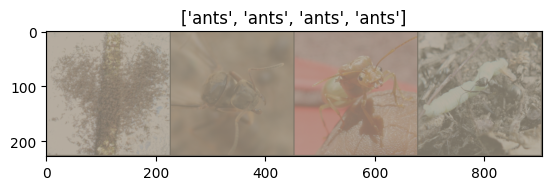

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(val_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_names[x] for x in classes])

In [ ]:
  # Now use the train and test functions to train and test the model
  device = "cpu"
  if (torch.cuda.is_available()):
      # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
      device = "cuda"
  print('Training on', device)

Training on cuda


In [ ]:
# TRAINING

def train(model, device, train_loader, optimizer, loss_criteria, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)

        # Reset the optimizer
        optimizer.zero_grad()

        # Push the data forward through the model layers
        output = model(data)

        # Get the loss
        loss = loss_criteria(output, data)

        # Keep a running total
        train_loss += loss.item()

        # Backpropagate
        loss.backward()
        optimizer.step()

        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss


def test(model, loss_criteria, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)

            # Get the predicted classes for this batch
            output = model(data)

            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # return average loss for the epoch
    return avg_loss

def visualize_model(model, loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_names[preds[j]]}, gt: {classes_names[labels[j].cpu()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def show_loss(epoch_nums, training_loss, validation_loss):
  plt.plot(epoch_nums, training_loss)
  plt.plot(epoch_nums, validation_loss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

In [ ]:
def do_train(model, lr=1e-3):
  # Create an instance of the model class and allocate it to the device
  model = model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Specify the loss criteria
  loss_criteria = nn.CrossEntropyLoss()

  # Track metrics in these arrays
  epoch_nums = []
  training_loss = []
  validation_loss = []

  # Train over 3 epochs (in a real scenario, you'd likely use many more)
  epochs = 3
  for epoch in range(1, epochs + 1):
          train_loss = train(model, device, train_loader, optimizer, loss_criteria, epoch)
          test_loss = test(model, loss_criteria, device, val_loader)
          epoch_nums.append(epoch)
          training_loss.append(train_loss)
          validation_loss.append(test_loss)

  return epoch_nums, training_loss, validation_loss